In [1]:
import cv2
import numpy as np
import pandas as pd
import os
import csv
import tensorflow as tf
import matplotlib.image as mpimg
from tqdm import tqdm

In [2]:
VIDEO_PATH = 'GOPR0485.MP4'
TEST_IMG_PATH = './test2/test_IMG/'
DRIVE_TEST_CSV_PATH = './test2/driving_test.csv'
TEST_PREDICT_PATH = './test2/test_predict/'

WEIGHTS = 'model-weights-Vtest.h5'
EVAL_SAMPLE_SIZE = 100 # Number of samples to evaluate to compute MSE

In [3]:
### Preprocessing helpers
def preprocess_image(image, to_size):
#     image_cropped = image[100:440, :-90] # -> (380, 550, 3)
#     image = cv2.resize(image_cropped, (220, 66), interpolation = cv2.INTER_AREA)
    image = cv2.resize(image, to_size, interpolation = cv2.INTER_AREA)
    return image


def preprocess_image_valid_from_path(image_path, speed, to_size):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = preprocess_image(img, to_size)
    return img, speed


In [4]:
from model import nvidia_model
from opticalHelpers import opticalFlowDenseDim3
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Activation, Dropout, Flatten, Dense, Lambda
from keras.layers import ELU
from keras.optimizers import Adam
# tf.python.control_flow_ops = tf
N_img_height = 66
N_img_width = 220
N_img_channels = 3

Using TensorFlow backend.


In [5]:
model = nvidia_model()
model.load_weights(WEIGHTS)

C:\Users\Yair\Code\speedChallenge\test_suite\model.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), name="conv1", strides=(2, 2), padding="valid", kernel_initializer="he_normal")`
  name = 'conv1'))
C:\Users\Yair\Code\speedChallenge\test_suite\model.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), name="conv2", strides=(2, 2), padding="valid", kernel_initializer="he_normal")`
  name = 'conv2'))
C:\Users\Yair\Code\speedChallenge\test_suite\model.py:39: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), name="conv3", strides=(2, 2), padding="valid", kernel_initializer="he_normal")`
  name = 'conv3'))
C:\Users\Yair\Code\speedChallenge\test_suite\model.py:46: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), name="conv4", strides=(1, 1), padding="valid", kernel_initializer="he_normal")`
  name = 'conv4'))
C:\Users\Yair\Code\speedChallenge\test_suite\model.py:53

In [6]:
cap = cv2.VideoCapture(VIDEO_PATH)
n_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
fps = cap.get(cv2.CAP_PROP_FPS)

# with open(DRIVE_TEST_CSV_PATH, 'w') as csvfile:
#     fieldnames = ['image_path', 'time', 'speed']
#     writer = csv.DictWriter(csvfile, fieldnames = fieldnames)
#     writer.writeheader()

#     for _ in range(int(n_frames/3)):
#         time = cap.get(cv2.CAP_PROP_POS_MSEC)
#         success, image = cap.read()
#         if success:
#             image_path = os.path.join(TEST_IMG_PATH, str(time) + '.jpg')

#             # save image to IMG folder
#             cv2.imwrite(image_path, image)

#             # write row to driving.csv
#             writer.writerow({'image_path': image_path, 
#                      'time':time,
#                      'speed':np.nan,
#                     })
cap.release()

In [7]:
fps/11.7552

5.099025107191705

In [9]:
list(range(0,20,5))

[0, 5, 10, 15]

In [10]:
data = pd.read_csv(DRIVE_TEST_CSV_PATH)
data.time = data.time/1000 # convert from ms to seconds (for the following conditionals)
predictions = []
for idx in tqdm(range(1, len(data) - 1, 5)):
    row_now = data.iloc[[idx]].reset_index()
    row_prev = data.iloc[[idx - 1]].reset_index()
    row_next = data.iloc[[idx + 1]].reset_index()

    # Find the 3 respective times to determine frame order (current -> next)

    time_now = row_now['time'].values[0]
    time_prev = row_prev['time'].values[0]
    time_next = row_next['time'].values[0]

    if time_now - time_prev > 0 and 0.0000001 < time_now - time_prev < 0.58: # 0.578111 is highest diff i have seen
        # in this case row_prev is x1 and row_now is x2
        row1 = row_prev
        row2 = row_now

    elif time_next - time_now > 0 and 0.0000001 < time_next - time_now < 0.58:
        # in this case row_now is x1 and row_next is x2
        row1 = row_now
        row2 = row_next

    x1, y1 = preprocess_image_valid_from_path(row1['image_path'].values[0],
                                              row1['speed'].values[0], (220, 66))
    x2, y2 = preprocess_image_valid_from_path(row2['image_path'].values[0],
                                              row2['speed'].values[0], (220, 66))

    img_diff = opticalFlowDenseDim3(x1, x2)
    img_diff_reshaped = img_diff.reshape(1, img_diff.shape[0], img_diff.shape[1], img_diff.shape[2])
    predictions.append(model.predict(img_diff_reshaped)[0][0])
#     error = abs(prediction - y2)


100%|██████████████████████████████████████████████████████████████████████████████| 1323/1323 [02:26<00:00,  8.99it/s]


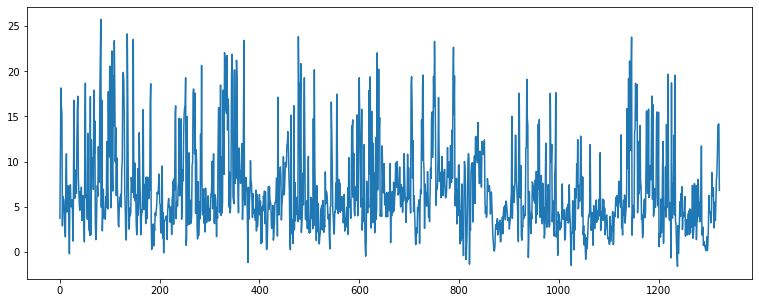

In [11]:
import matplotlib.pyplot as plt
% matplotlib inline
plt.figure(figsize=(13,5))
plt.plot(predictions)

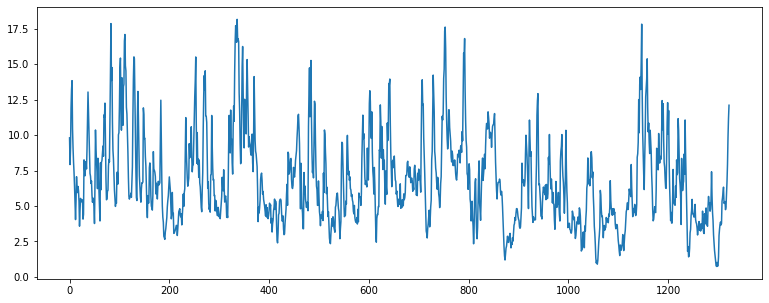

In [12]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
smooth_model = SimpleExpSmoothing(predictions)
fitted_smooth_model = smooth_model.fit()
smoothed_preds = fitted_smooth_model.predict(start=0,end=len(predictions)-1)

plt.figure(figsize=(13,5))
plt.plot(smoothed_preds)

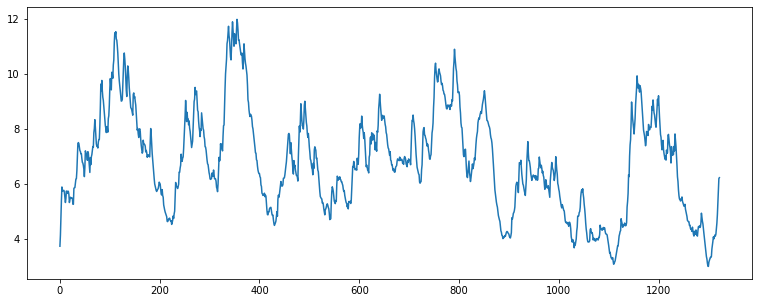

In [19]:
smoothed_preds = predictions[:]
for idx in range(1, len(predictions)):
    smoothed_preds[idx] = 0.05 * smoothed_preds[idx] + 0.95 * smoothed_preds[idx-1]
plt.figure(figsize=(13,5))
plt.plot(smoothed_preds)

In [21]:
rep_smoothed_preds = np.repeat(smoothed_preds,5)
len(rep_smoothed_preds)

6615

In [25]:
for idx in range(0, len(rep_smoothed_preds), 2): # reduce fps to ~30 fps
    predict_path = os.path.join(TEST_PREDICT_PATH, str(idx+1) + '.jpg')
                                   
    # overwrite the prediction of y2 onto image x2
    # save overwritten image x2 to new directory ./data/predict

                                   
    # Make a copy
    x2_copy, _ = preprocess_image_valid_from_path(data.image_path[idx+1], 0, (1280, 720))
    
    # to write new image via openCV
    offset = 70
    font = cv2.FONT_HERSHEY_SIMPLEX
#     x2_copy = cv2.resize(x2_copy, (640, 480), interpolation = cv2.INTER_AREA)
    cv2.putText(x2_copy, str(3.6*rep_smoothed_preds[idx])[:4] + ' km/h',(30,offset), font, 2,(0,0,0),2,cv2.LINE_AA)
#     cv2.putText(x2_copy,'pred: ' + str(prediction[0][0])[:5],(5,offset), font, 1,(0,0,0),1,cv2.LINE_AA)
#     cv2.putText(x2_copy,'truth: ' + str(y2)[:5],(5,offset * 2), font, 1,(0,20,255),1,cv2.LINE_AA)
#     cv2.putText(x2_copy, 'error: ' + str(error[0][0])[:5], (5, offset*3),font, 1, (255, 0, 0),1, cv2.LINE_AA)
    
    # convert back to BGR for writing
    x2_copy = cv2.cvtColor(x2_copy, cv2.COLOR_RGB2BGR)
    cv2.imwrite(predict_path, x2_copy)
    
print('done creating test predictions')

done creating test predictions


In [29]:
from moviepy.editor import VideoFileClip
from moviepy.editor import ImageSequenceClip
import glob
import os

images = [TEST_PREDICT_PATH + str(i+1) + '.jpg' for i in range(0, len(rep_smoothed_preds), 2)]
clip = ImageSequenceClip(images, fps=fps/2)
clip.write_videofile("movie-vTest.mp4", fps = fps/2)
print('done creating video')

[MoviePy] >>>> Building video movie-vTest.mp4
[MoviePy] Writing video movie-vTest.mp4




  0%|                                                                                         | 0/3308 [00:00<?, ?it/s]

  0%|                                                                                 | 1/3308 [00:00<05:35,  9.87it/s]

  0%|                                                                                 | 5/3308 [00:00<04:20, 12.70it/s]

  0%|▏                                                                               | 10/3308 [00:00<03:24, 16.11it/s]

  0%|▎                                                                               | 14/3308 [00:00<02:48, 19.51it/s]

  1%|▍                                                                               | 18/3308 [00:00<02:22, 23.06it/s]

  1%|▌                                                                               | 23/3308 [00:00<02:02, 26.79it/s]

  1%|▋                                                                               | 28/3308 [00:00<01:48, 30.23it/s]

  1%|▊                        

  6%|████▍                                                                          | 184/3308 [00:10<03:37, 14.39it/s]

  6%|████▍                                                                          | 186/3308 [00:10<04:26, 11.73it/s]

  6%|████▍                                                                          | 188/3308 [00:10<03:56, 13.18it/s]

  6%|████▌                                                                          | 191/3308 [00:10<03:44, 13.91it/s]

  6%|████▌                                                                          | 193/3308 [00:10<03:45, 13.79it/s]

  6%|████▋                                                                          | 195/3308 [00:11<03:56, 13.16it/s]

  6%|████▋                                                                          | 197/3308 [00:11<03:39, 14.17it/s]

  6%|████▊                                                                          | 199/3308 [00:11<03:40, 14.08it/s]

  6%|████▊                      

 10%|███████▉                                                                       | 332/3308 [00:20<03:21, 14.76it/s]

 10%|███████▉                                                                       | 334/3308 [00:20<03:32, 14.00it/s]

 10%|████████                                                                       | 336/3308 [00:20<03:18, 14.97it/s]

 10%|████████                                                                       | 338/3308 [00:21<03:30, 14.13it/s]

 10%|████████▏                                                                      | 341/3308 [00:21<03:19, 14.90it/s]

 10%|████████▏                                                                      | 343/3308 [00:21<03:07, 15.83it/s]

 10%|████████▎                                                                      | 346/3308 [00:21<03:20, 14.74it/s]

 11%|████████▎                                                                      | 348/3308 [00:21<03:10, 15.56it/s]

 11%|████████▎                  

 15%|███████████▌                                                                   | 485/3308 [00:31<03:40, 12.79it/s]

 15%|███████████▋                                                                   | 487/3308 [00:31<03:31, 13.31it/s]

 15%|███████████▋                                                                   | 489/3308 [00:31<03:25, 13.70it/s]

 15%|███████████▋                                                                   | 491/3308 [00:31<03:50, 12.24it/s]

 15%|███████████▊                                                                   | 493/3308 [00:31<03:33, 13.19it/s]

 15%|███████████▊                                                                   | 495/3308 [00:31<03:28, 13.50it/s]

 15%|███████████▉                                                                   | 498/3308 [00:32<03:46, 12.40it/s]

 15%|███████████▉                                                                   | 500/3308 [00:32<03:27, 13.54it/s]

 15%|████████████               

 19%|███████████████▏                                                               | 635/3308 [00:42<03:23, 13.12it/s]

 19%|███████████████▏                                                               | 637/3308 [00:42<03:42, 12.00it/s]

 19%|███████████████▎                                                               | 639/3308 [00:43<03:22, 13.20it/s]

 19%|███████████████▎                                                               | 641/3308 [00:43<03:23, 13.08it/s]

 19%|███████████████▎                                                               | 643/3308 [00:43<03:05, 14.35it/s]

 19%|███████████████▍                                                               | 645/3308 [00:43<03:48, 11.63it/s]

 20%|███████████████▍                                                               | 647/3308 [00:43<03:34, 12.41it/s]

 20%|███████████████▍                                                               | 649/3308 [00:43<03:16, 13.55it/s]

 20%|███████████████▌           

 24%|██████████████████▌                                                            | 779/3308 [00:53<03:08, 13.41it/s]

 24%|██████████████████▋                                                            | 781/3308 [00:53<03:17, 12.82it/s]

 24%|██████████████████▋                                                            | 784/3308 [00:53<03:22, 12.47it/s]

 24%|██████████████████▊                                                            | 786/3308 [00:53<03:00, 13.94it/s]

 24%|██████████████████▊                                                            | 788/3308 [00:53<02:53, 14.53it/s]

 24%|██████████████████▊                                                            | 790/3308 [00:53<02:40, 15.68it/s]

 24%|██████████████████▉                                                            | 792/3308 [00:54<03:18, 12.68it/s]

 24%|██████████████████▉                                                            | 794/3308 [00:54<02:57, 14.13it/s]

 24%|███████████████████        

 28%|██████████████████████                                                         | 925/3308 [01:03<02:39, 14.96it/s]

 28%|██████████████████████▏                                                        | 927/3308 [01:03<02:31, 15.73it/s]

 28%|██████████████████████▏                                                        | 929/3308 [01:04<03:10, 12.51it/s]

 28%|██████████████████████▎                                                        | 932/3308 [01:04<02:46, 14.30it/s]

 28%|██████████████████████▎                                                        | 935/3308 [01:04<02:24, 16.41it/s]

 28%|██████████████████████▍                                                        | 937/3308 [01:04<03:15, 12.16it/s]

 28%|██████████████████████▍                                                        | 939/3308 [01:04<02:54, 13.55it/s]

 28%|██████████████████████▍                                                        | 942/3308 [01:04<02:30, 15.71it/s]

 29%|██████████████████████▌    

 32%|█████████████████████████▎                                                    | 1071/3308 [01:14<03:13, 11.54it/s]

 32%|█████████████████████████▎                                                    | 1073/3308 [01:15<02:58, 12.52it/s]

 32%|█████████████████████████▎                                                    | 1075/3308 [01:15<02:38, 14.10it/s]

 33%|█████████████████████████▍                                                    | 1077/3308 [01:15<02:29, 14.92it/s]

 33%|█████████████████████████▍                                                    | 1079/3308 [01:15<03:06, 11.97it/s]

 33%|█████████████████████████▌                                                    | 1082/3308 [01:15<02:40, 13.88it/s]

 33%|█████████████████████████▌                                                    | 1084/3308 [01:15<02:25, 15.28it/s]

 33%|█████████████████████████▌                                                    | 1086/3308 [01:15<02:19, 15.97it/s]

 33%|█████████████████████████▋ 

 37%|████████████████████████████▉                                                 | 1226/3308 [01:25<02:09, 16.10it/s]

 37%|████████████████████████████▉                                                 | 1229/3308 [01:25<01:58, 17.52it/s]

 37%|█████████████████████████████                                                 | 1232/3308 [01:25<01:55, 18.00it/s]

 37%|█████████████████████████████                                                 | 1234/3308 [01:25<02:25, 14.27it/s]

 37%|█████████████████████████████▏                                                | 1237/3308 [01:25<02:12, 15.66it/s]

 37%|█████████████████████████████▏                                                | 1239/3308 [01:26<02:24, 14.31it/s]

 38%|█████████████████████████████▎                                                | 1242/3308 [01:26<02:31, 13.64it/s]

 38%|█████████████████████████████▎                                                | 1244/3308 [01:26<02:16, 15.08it/s]

 38%|███████████████████████████

 42%|████████████████████████████████▍                                             | 1375/3308 [01:35<02:09, 14.94it/s]

 42%|████████████████████████████████▍                                             | 1377/3308 [01:35<02:35, 12.43it/s]

 42%|████████████████████████████████▌                                             | 1379/3308 [01:35<02:31, 12.74it/s]

 42%|████████████████████████████████▌                                             | 1382/3308 [01:35<02:11, 14.67it/s]

 42%|████████████████████████████████▋                                             | 1384/3308 [01:35<02:06, 15.22it/s]

 42%|████████████████████████████████▋                                             | 1386/3308 [01:35<02:38, 12.11it/s]

 42%|████████████████████████████████▊                                             | 1389/3308 [01:36<02:13, 14.41it/s]

 42%|████████████████████████████████▊                                             | 1391/3308 [01:36<02:05, 15.29it/s]

 42%|███████████████████████████

 46%|███████████████████████████████████▉                                          | 1525/3308 [01:45<02:13, 13.35it/s]

 46%|████████████████████████████████████                                          | 1528/3308 [01:45<02:03, 14.36it/s]

 46%|████████████████████████████████████                                          | 1530/3308 [01:45<02:11, 13.52it/s]

 46%|████████████████████████████████████                                          | 1532/3308 [01:45<02:01, 14.59it/s]

 46%|████████████████████████████████████▏                                         | 1534/3308 [01:45<02:07, 13.89it/s]

 46%|████████████████████████████████████▏                                         | 1537/3308 [01:45<01:50, 16.03it/s]

 47%|████████████████████████████████████▎                                         | 1539/3308 [01:46<01:54, 15.46it/s]

 47%|████████████████████████████████████▎                                         | 1541/3308 [01:46<01:48, 16.27it/s]

 47%|███████████████████████████

 51%|███████████████████████████████████████▍                                      | 1674/3308 [01:55<02:04, 13.18it/s]

 51%|███████████████████████████████████████▌                                      | 1676/3308 [01:55<01:53, 14.43it/s]

 51%|███████████████████████████████████████▌                                      | 1678/3308 [01:55<02:13, 12.18it/s]

 51%|███████████████████████████████████████▌                                      | 1680/3308 [01:55<02:03, 13.14it/s]

 51%|███████████████████████████████████████▋                                      | 1682/3308 [01:56<02:00, 13.47it/s]

 51%|███████████████████████████████████████▋                                      | 1684/3308 [01:56<01:48, 14.93it/s]

 51%|███████████████████████████████████████▊                                      | 1686/3308 [01:56<01:57, 13.76it/s]

 51%|███████████████████████████████████████▊                                      | 1688/3308 [01:56<01:49, 14.78it/s]

 51%|███████████████████████████

 55%|███████████████████████████████████████████                                   | 1824/3308 [02:05<01:42, 14.46it/s]

 55%|███████████████████████████████████████████                                   | 1826/3308 [02:06<01:41, 14.66it/s]

 55%|███████████████████████████████████████████                                   | 1828/3308 [02:06<01:49, 13.49it/s]

 55%|███████████████████████████████████████████▏                                  | 1830/3308 [02:06<01:41, 14.55it/s]

 55%|███████████████████████████████████████████▏                                  | 1833/3308 [02:06<01:29, 16.53it/s]

 55%|███████████████████████████████████████████▎                                  | 1835/3308 [02:06<01:58, 12.38it/s]

 56%|███████████████████████████████████████████▎                                  | 1837/3308 [02:06<01:47, 13.64it/s]

 56%|███████████████████████████████████████████▍                                  | 1840/3308 [02:06<01:35, 15.40it/s]

 56%|███████████████████████████

 60%|██████████████████████████████████████████████▌                               | 1973/3308 [02:16<01:39, 13.39it/s]

 60%|██████████████████████████████████████████████▌                               | 1975/3308 [02:16<01:42, 13.01it/s]

 60%|██████████████████████████████████████████████▌                               | 1977/3308 [02:17<01:58, 11.21it/s]

 60%|██████████████████████████████████████████████▋                               | 1979/3308 [02:17<01:51, 11.90it/s]

 60%|██████████████████████████████████████████████▋                               | 1982/3308 [02:17<01:40, 13.22it/s]

 60%|██████████████████████████████████████████████▊                               | 1984/3308 [02:17<01:41, 13.10it/s]

 60%|██████████████████████████████████████████████▊                               | 1986/3308 [02:17<02:00, 10.96it/s]

 60%|██████████████████████████████████████████████▉                               | 1989/3308 [02:17<01:41, 12.98it/s]

 60%|███████████████████████████

 64%|█████████████████████████████████████████████████▉                            | 2116/3308 [02:27<01:29, 13.36it/s]

 64%|█████████████████████████████████████████████████▉                            | 2118/3308 [02:27<01:35, 12.50it/s]

 64%|█████████████████████████████████████████████████▉                            | 2120/3308 [02:27<01:42, 11.55it/s]

 64%|██████████████████████████████████████████████████                            | 2123/3308 [02:27<01:26, 13.62it/s]

 64%|██████████████████████████████████████████████████                            | 2125/3308 [02:28<01:26, 13.70it/s]

 64%|██████████████████████████████████████████████████▏                           | 2127/3308 [02:28<01:37, 12.15it/s]

 64%|██████████████████████████████████████████████████▏                           | 2129/3308 [02:28<01:27, 13.44it/s]

 64%|██████████████████████████████████████████████████▏                           | 2131/3308 [02:28<01:19, 14.77it/s]

 64%|███████████████████████████

 68%|█████████████████████████████████████████████████████▏                        | 2255/3308 [02:37<01:12, 14.52it/s]

 68%|█████████████████████████████████████████████████████▏                        | 2257/3308 [02:37<01:12, 14.57it/s]

 68%|█████████████████████████████████████████████████████▎                        | 2260/3308 [02:37<01:12, 14.36it/s]

 68%|█████████████████████████████████████████████████████▎                        | 2262/3308 [02:37<01:08, 15.26it/s]

 68%|█████████████████████████████████████████████████████▍                        | 2265/3308 [02:38<01:14, 13.99it/s]

 69%|█████████████████████████████████████████████████████▍                        | 2267/3308 [02:38<01:07, 15.38it/s]

 69%|█████████████████████████████████████████████████████▌                        | 2270/3308 [02:38<00:59, 17.38it/s]

 69%|█████████████████████████████████████████████████████▌                        | 2272/3308 [02:38<01:21, 12.71it/s]

 69%|███████████████████████████

 73%|████████████████████████████████████████████████████████▊                     | 2409/3308 [02:48<01:04, 13.84it/s]

 73%|████████████████████████████████████████████████████████▊                     | 2411/3308 [02:49<01:05, 13.74it/s]

 73%|████████████████████████████████████████████████████████▉                     | 2413/3308 [02:49<01:00, 14.89it/s]

 73%|████████████████████████████████████████████████████████▉                     | 2415/3308 [02:49<01:10, 12.69it/s]

 73%|█████████████████████████████████████████████████████████                     | 2418/3308 [02:49<01:04, 13.82it/s]

 73%|█████████████████████████████████████████████████████████                     | 2420/3308 [02:49<01:02, 14.19it/s]

 73%|█████████████████████████████████████████████████████████                     | 2422/3308 [02:49<01:02, 14.10it/s]

 73%|█████████████████████████████████████████████████████████▏                    | 2425/3308 [02:49<00:57, 15.42it/s]

 73%|███████████████████████████

 78%|████████████████████████████████████████████████████████████▍                 | 2564/3308 [02:59<01:06, 11.16it/s]

 78%|████████████████████████████████████████████████████████████▌                 | 2566/3308 [02:59<01:01, 12.12it/s]

 78%|████████████████████████████████████████████████████████████▌                 | 2569/3308 [03:00<00:51, 14.42it/s]

 78%|████████████████████████████████████████████████████████████▌                 | 2571/3308 [03:00<00:51, 14.38it/s]

 78%|████████████████████████████████████████████████████████████▋                 | 2573/3308 [03:00<01:02, 11.72it/s]

 78%|████████████████████████████████████████████████████████████▋                 | 2576/3308 [03:00<00:52, 14.02it/s]

 78%|████████████████████████████████████████████████████████████▊                 | 2578/3308 [03:00<00:50, 14.60it/s]

 78%|████████████████████████████████████████████████████████████▊                 | 2580/3308 [03:00<00:58, 12.44it/s]

 78%|███████████████████████████

 82%|███████████████████████████████████████████████████████████████▉              | 2714/3308 [03:10<00:39, 15.11it/s]

 82%|████████████████████████████████████████████████████████████████              | 2716/3308 [03:10<00:44, 13.31it/s]

 82%|████████████████████████████████████████████████████████████████              | 2718/3308 [03:10<00:40, 14.41it/s]

 82%|████████████████████████████████████████████████████████████████▏             | 2720/3308 [03:10<00:42, 13.90it/s]

 82%|████████████████████████████████████████████████████████████████▏             | 2722/3308 [03:11<00:43, 13.45it/s]

 82%|████████████████████████████████████████████████████████████████▏             | 2724/3308 [03:11<00:43, 13.58it/s]

 82%|████████████████████████████████████████████████████████████████▎             | 2726/3308 [03:11<00:39, 14.63it/s]

 82%|████████████████████████████████████████████████████████████████▎             | 2728/3308 [03:11<00:40, 14.27it/s]

 83%|███████████████████████████

 86%|███████████████████████████████████████████████████████████████████▍          | 2859/3308 [03:20<00:33, 13.54it/s]

 86%|███████████████████████████████████████████████████████████████████▍          | 2861/3308 [03:20<00:31, 14.00it/s]

 87%|███████████████████████████████████████████████████████████████████▌          | 2863/3308 [03:20<00:32, 13.66it/s]

 87%|███████████████████████████████████████████████████████████████████▌          | 2865/3308 [03:20<00:31, 14.12it/s]

 87%|███████████████████████████████████████████████████████████████████▌          | 2867/3308 [03:20<00:28, 15.45it/s]

 87%|███████████████████████████████████████████████████████████████████▋          | 2869/3308 [03:21<00:34, 12.58it/s]

 87%|███████████████████████████████████████████████████████████████████▋          | 2872/3308 [03:21<00:29, 14.72it/s]

 87%|███████████████████████████████████████████████████████████████████▊          | 2874/3308 [03:21<00:29, 14.80it/s]

 87%|███████████████████████████

 91%|██████████████████████████████████████████████████████████████████████▉       | 3008/3308 [03:31<00:22, 13.18it/s]

 91%|██████████████████████████████████████████████████████████████████████▉       | 3010/3308 [03:31<00:23, 12.45it/s]

 91%|███████████████████████████████████████████████████████████████████████       | 3012/3308 [03:31<00:22, 13.05it/s]

 91%|███████████████████████████████████████████████████████████████████████       | 3014/3308 [03:31<00:20, 14.17it/s]

 91%|███████████████████████████████████████████████████████████████████████       | 3016/3308 [03:31<00:18, 15.47it/s]

 91%|███████████████████████████████████████████████████████████████████████▏      | 3018/3308 [03:32<00:19, 14.67it/s]

 91%|███████████████████████████████████████████████████████████████████████▏      | 3020/3308 [03:32<00:18, 15.94it/s]

 91%|███████████████████████████████████████████████████████████████████████▎      | 3022/3308 [03:32<00:21, 13.48it/s]

 91%|███████████████████████████

 95%|██████████████████████████████████████████████████████████████████████████▍   | 3155/3308 [03:41<00:11, 13.17it/s]

 95%|██████████████████████████████████████████████████████████████████████████▍   | 3157/3308 [03:41<00:11, 12.75it/s]

 95%|██████████████████████████████████████████████████████████████████████████▍   | 3159/3308 [03:42<00:10, 14.26it/s]

 96%|██████████████████████████████████████████████████████████████████████████▌   | 3161/3308 [03:42<00:11, 13.20it/s]

 96%|██████████████████████████████████████████████████████████████████████████▌   | 3164/3308 [03:42<00:09, 15.03it/s]

 96%|██████████████████████████████████████████████████████████████████████████▋   | 3166/3308 [03:42<00:10, 13.44it/s]

 96%|██████████████████████████████████████████████████████████████████████████▋   | 3168/3308 [03:42<00:09, 14.39it/s]

 96%|██████████████████████████████████████████████████████████████████████████▋   | 3170/3308 [03:42<00:09, 14.10it/s]

 96%|███████████████████████████

100%|█████████████████████████████████████████████████████████████████████████████▉| 3303/3308 [03:52<00:00, 15.59it/s]

100%|█████████████████████████████████████████████████████████████████████████████▉| 3305/3308 [03:52<00:00, 13.44it/s]

100%|█████████████████████████████████████████████████████████████████████████████▉| 3307/3308 [03:52<00:00, 14.42it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 3308/3308 [03:52<00:00, 14.22it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: movie-vTest.mp4 

done creating video


In [83]:
import pickle

with open('predictions.pickle', 'wb') as handle:
    pickle.dump(predictions, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [84]:
with open('predictions.pickle', 'rb') as handle:
    b = pickle.load(handle)

In [85]:
b == predictions

True